In [5]:
#getting rid of noise
!pip install noisereduce 
#coverting .mp3 to .wav
!pip install pydub 
#creating spectrogram for .wav file
!pip install librosa

# DO NOT RE RUN THIS BLOCK


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.9/377.9 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 36.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<timed exec>:28: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.


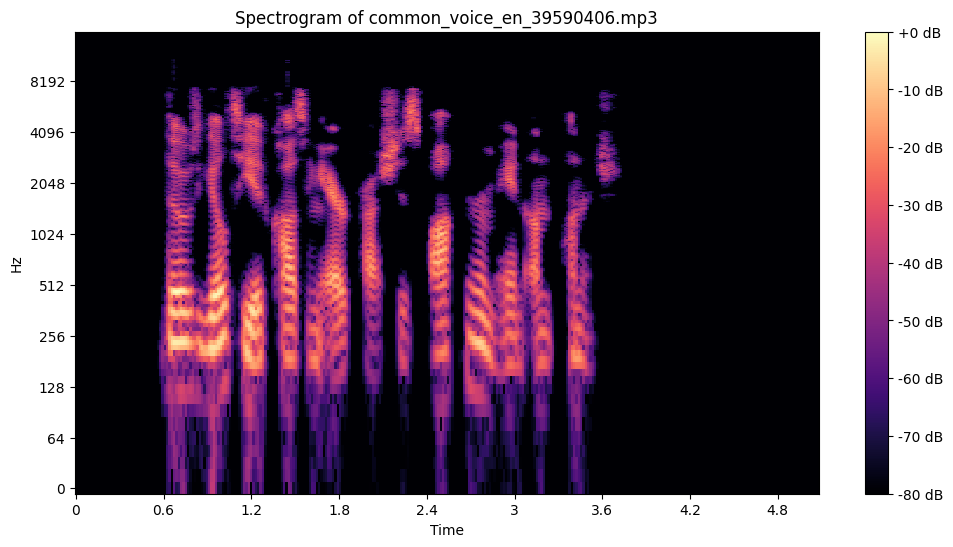

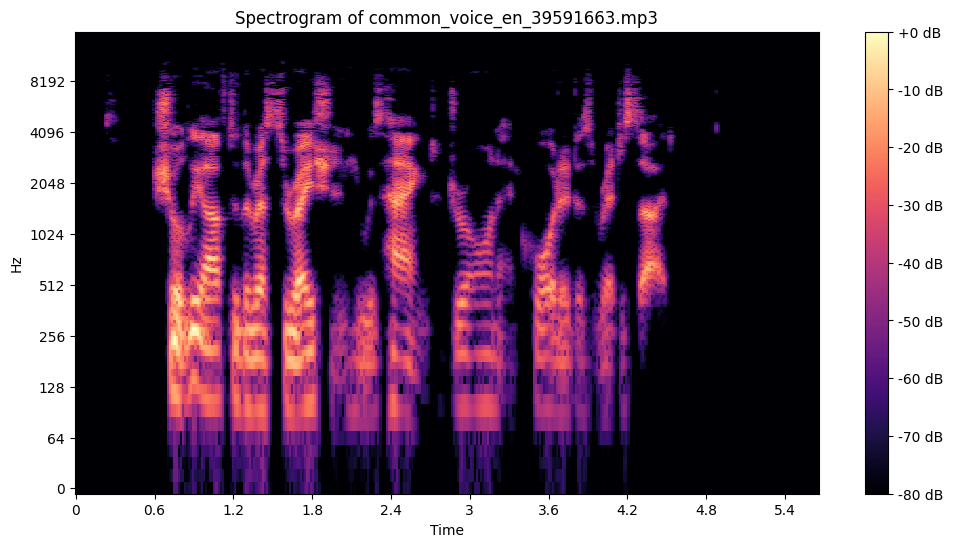

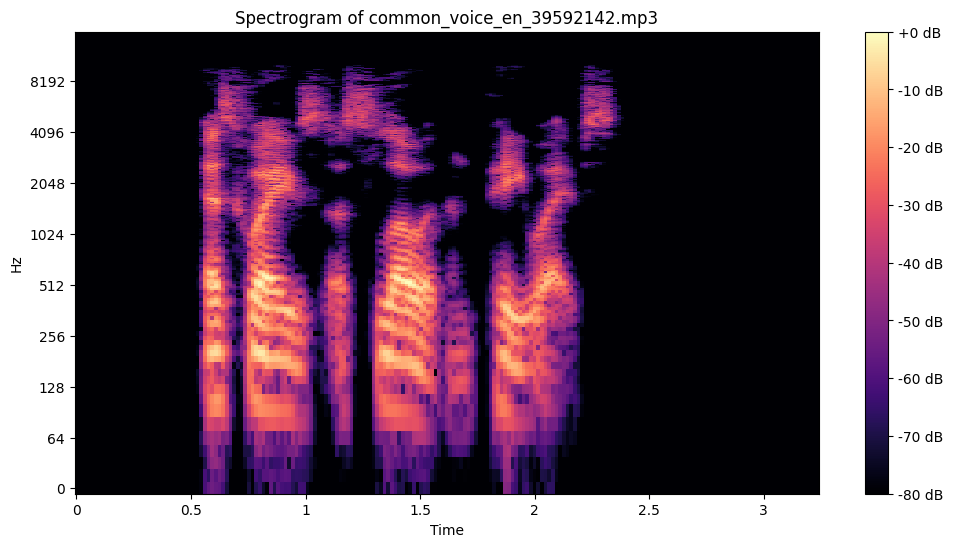

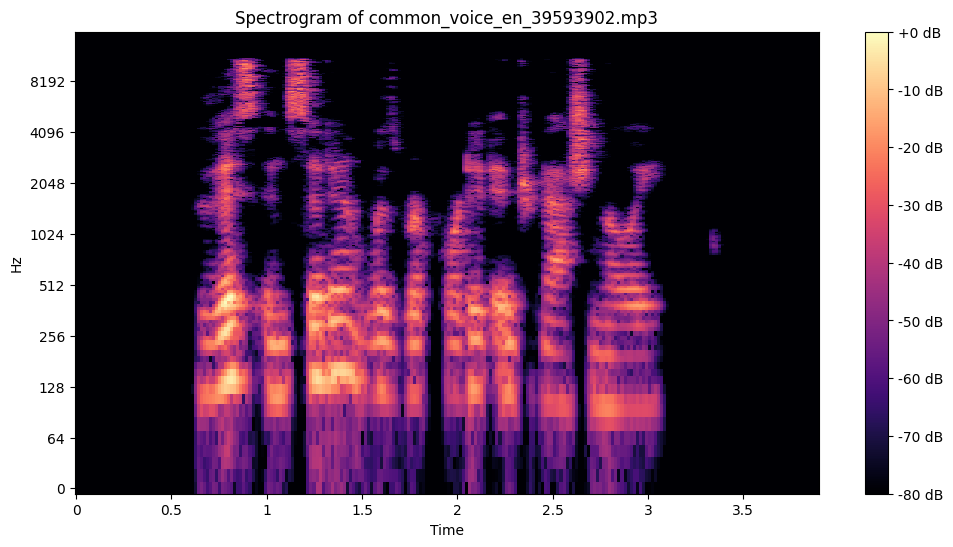

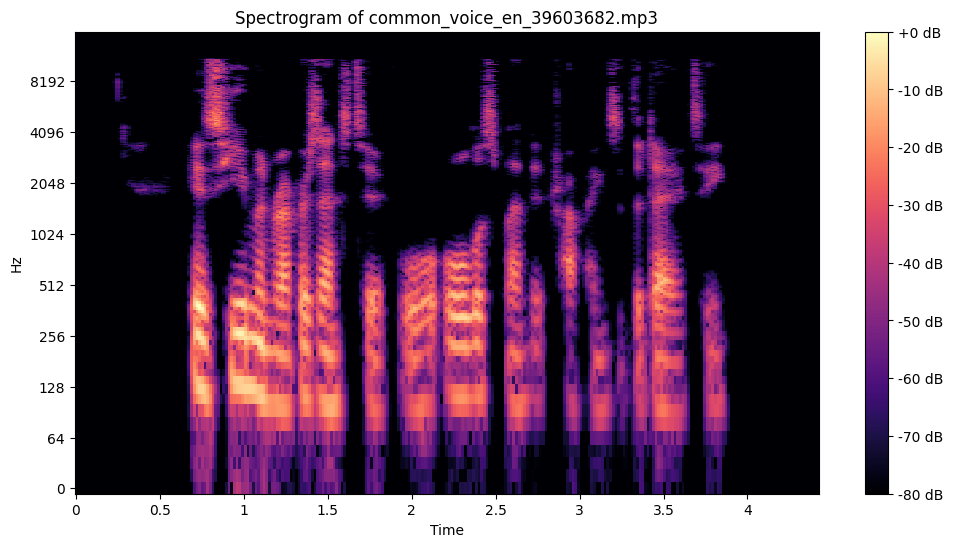

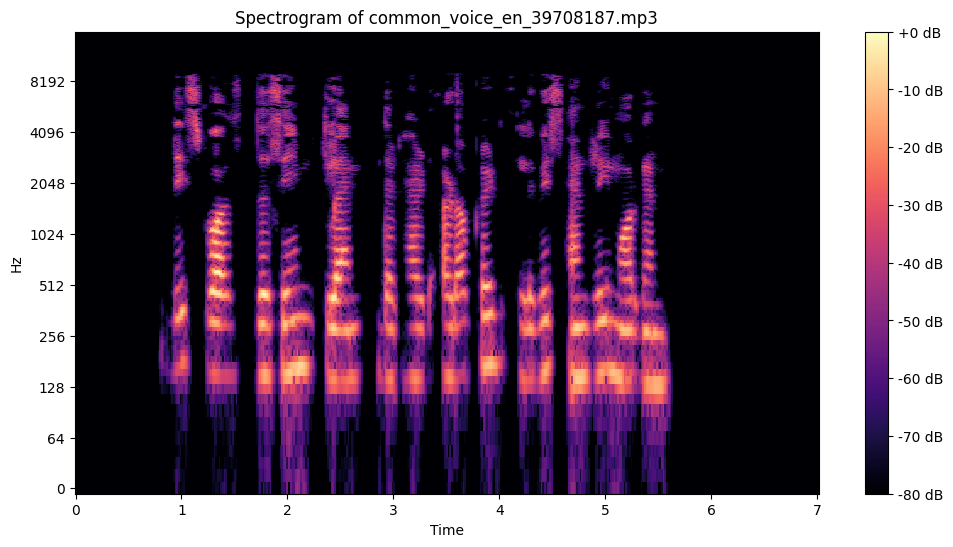

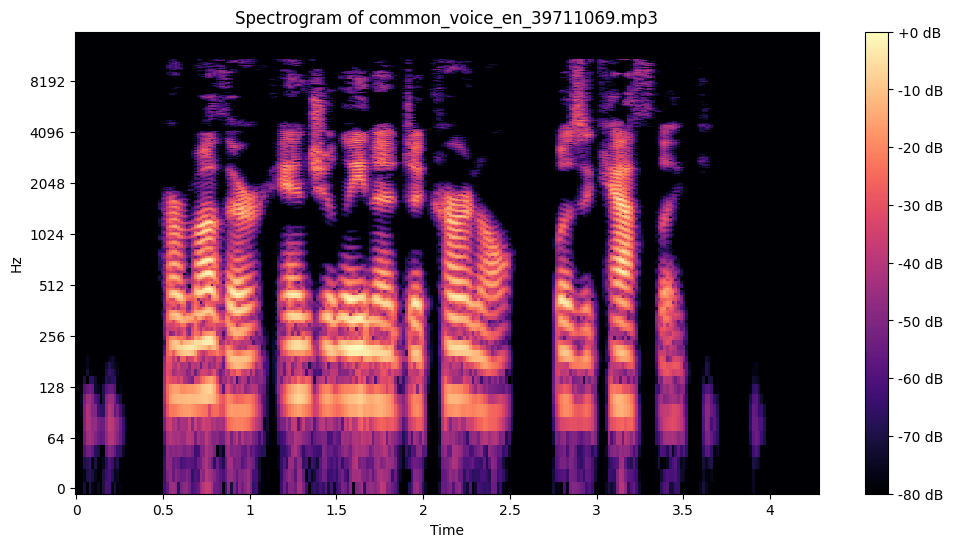

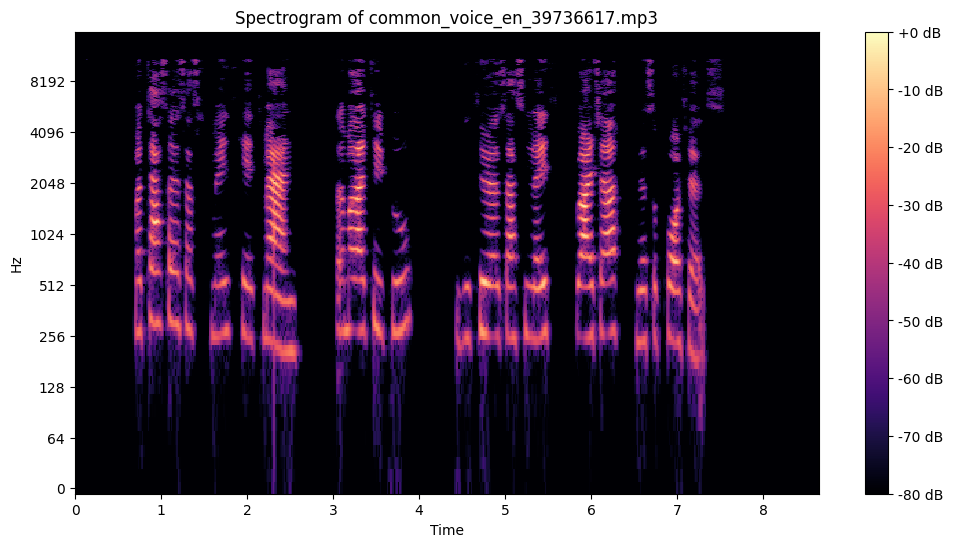

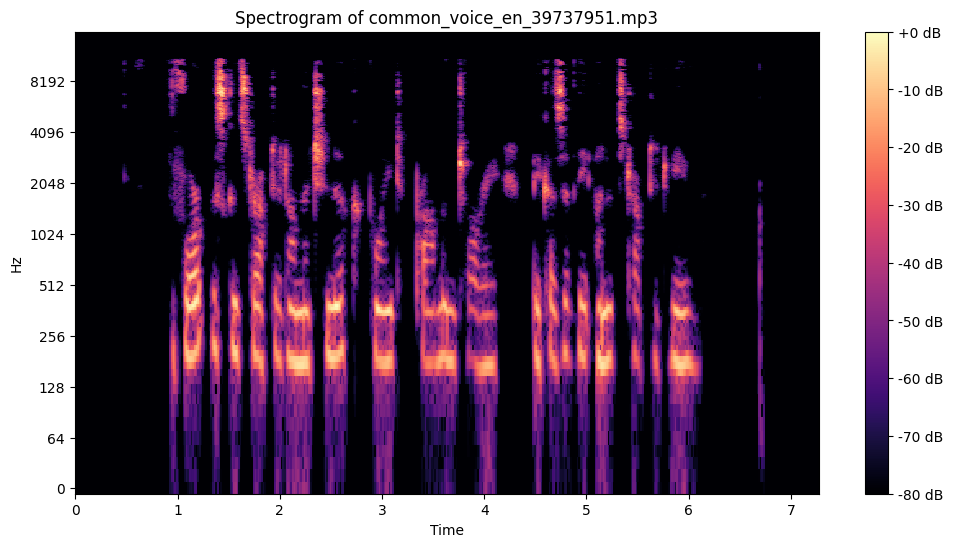

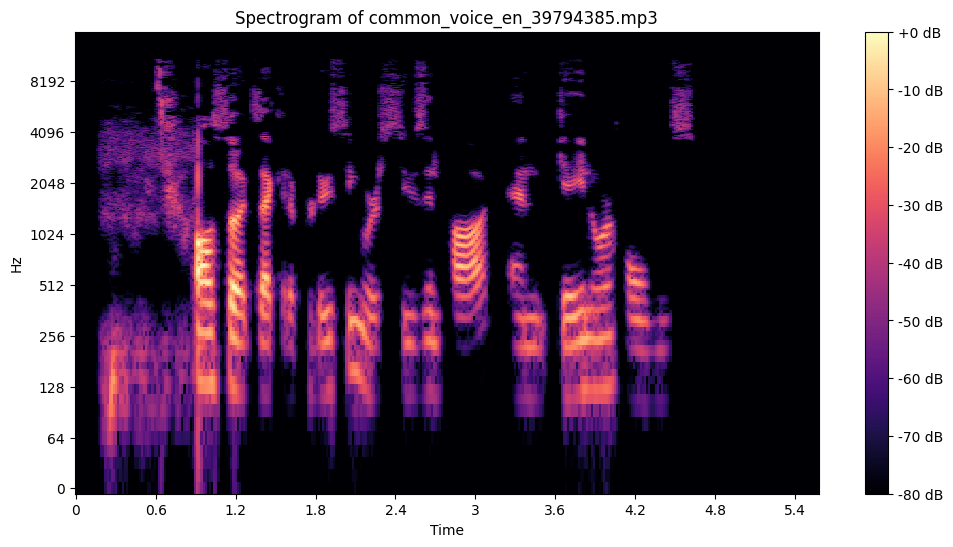

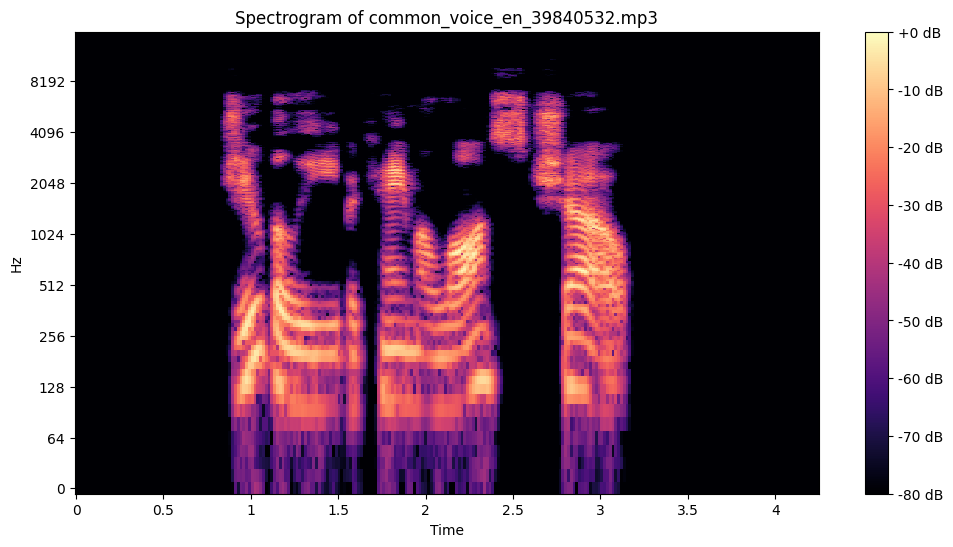

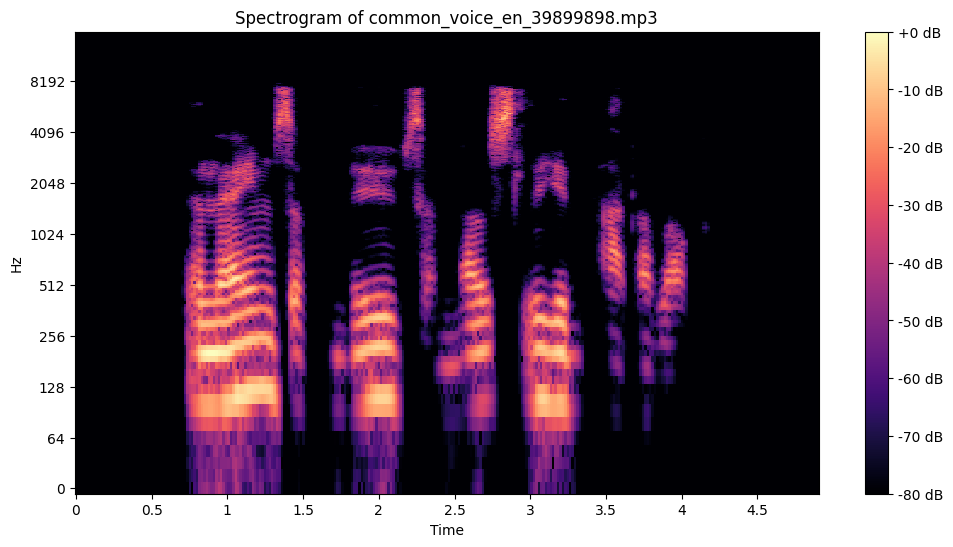

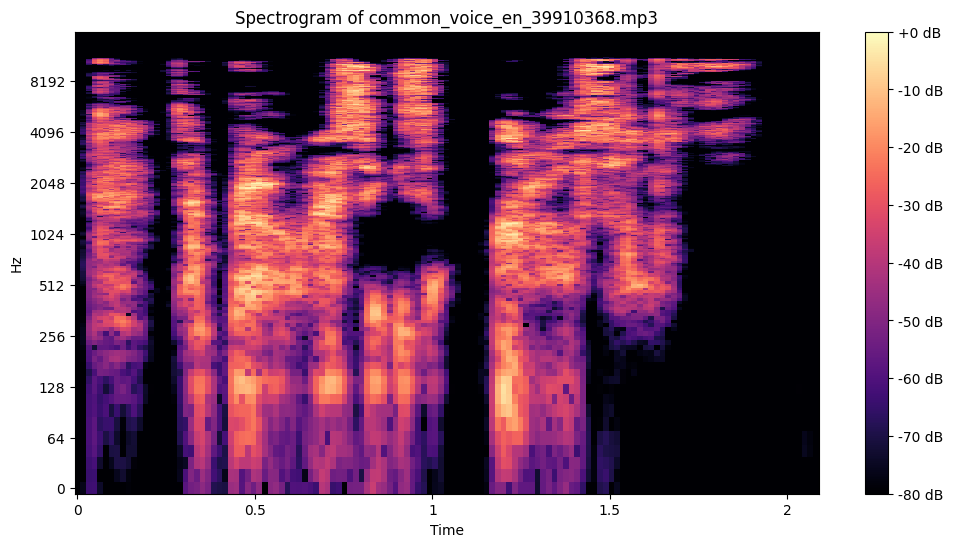

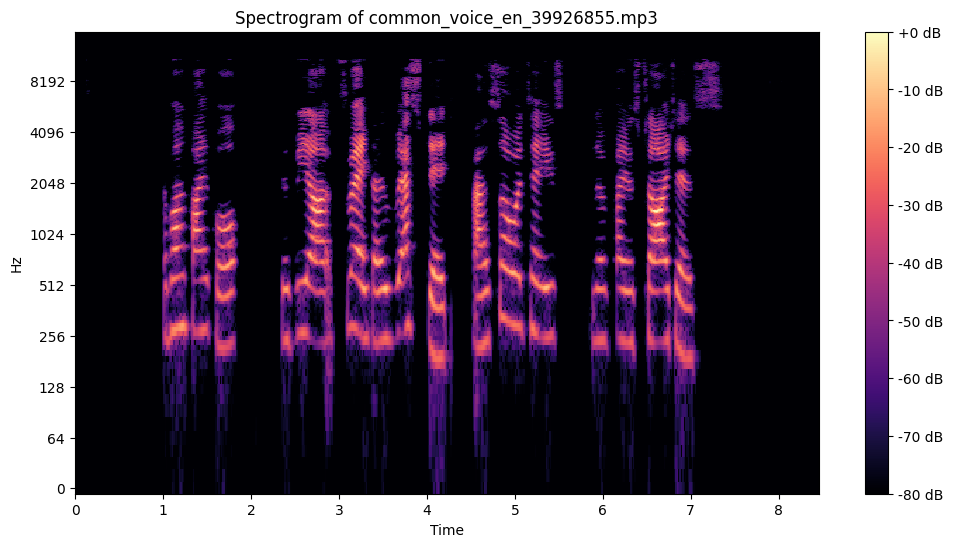

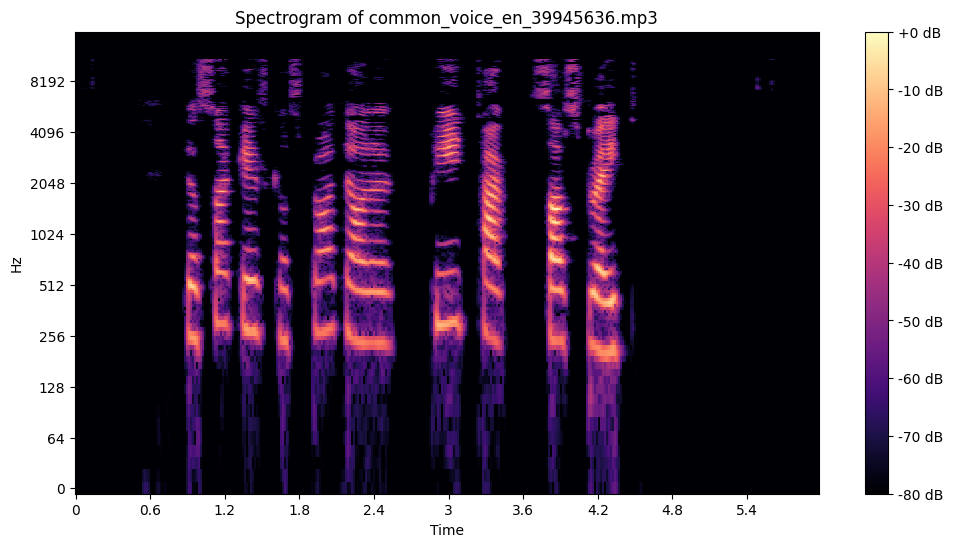

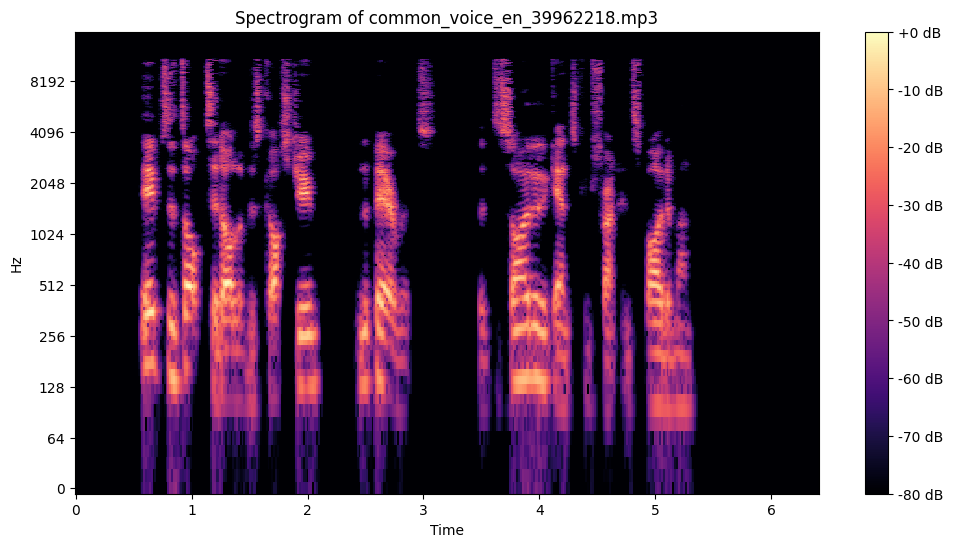

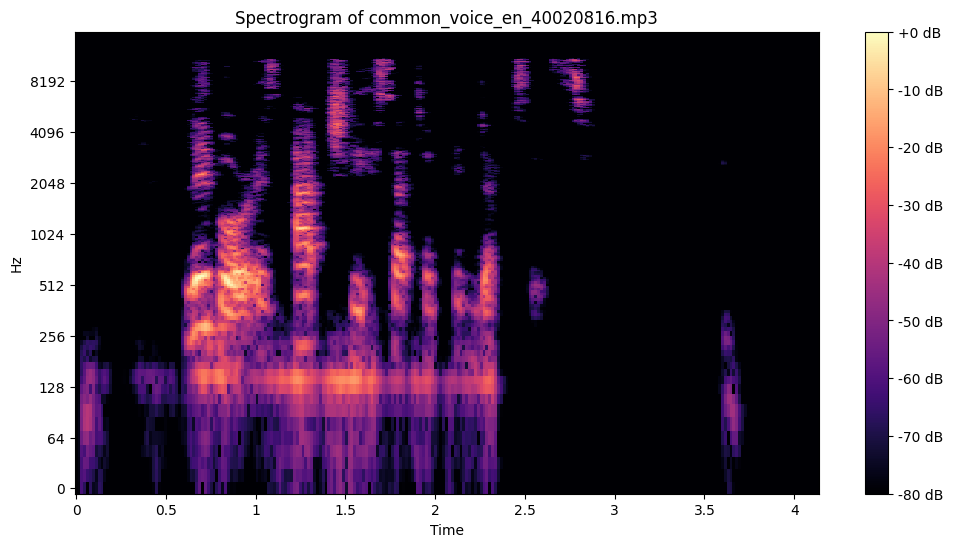

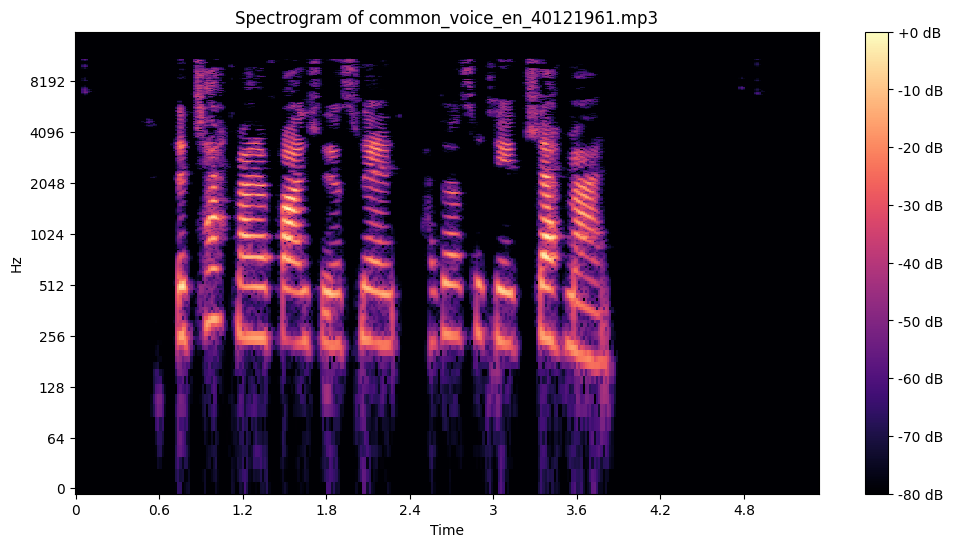

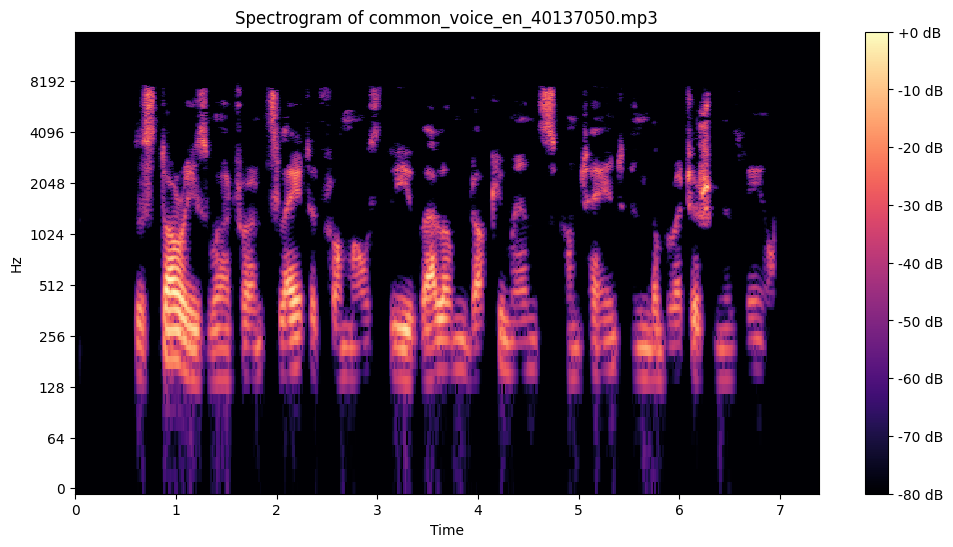

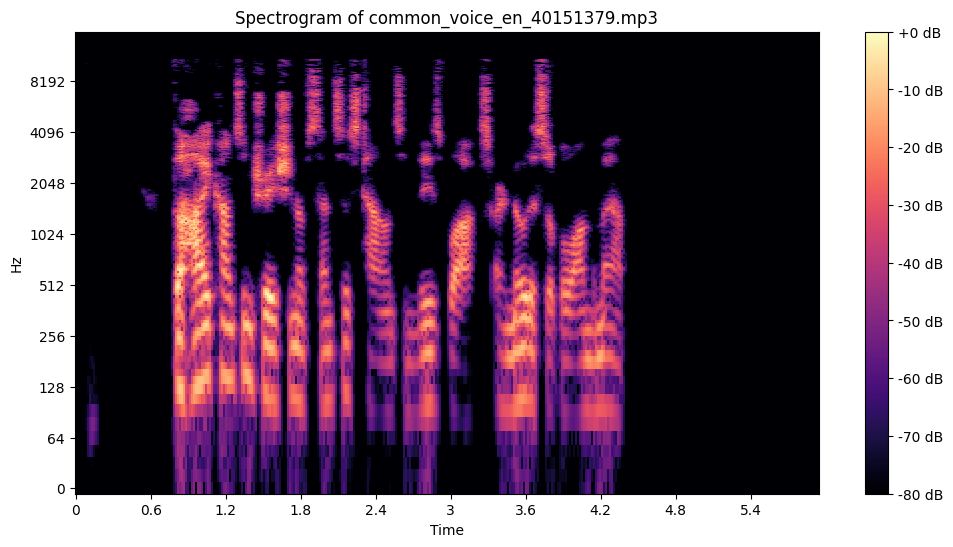

CPU times: user 19.5 s, sys: 1.99 s, total: 21.5 s
Wall time: 27.3 s


In [6]:
%%time

import os 
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import glob
import librosa
import soundfile as sf
import noisereduce as nr

mp3_folder = "/work/clips/*.mp3"
files = glob.glob(mp3_folder)

# file = "/work/clips/common_voice_en_39590406.mp3"
for file in files:

    y, sr = librosa.load(file, sr=None)

    wav_io = BytesIO()
    sf.write(wav_io, y, sr, format='WAV')
    wav_io.seek(0)


    y_wav, sr_wav = sf.read(wav_io)

    reduced_noise = nr.reduce_noise(y=y_wav, sr=sr_wav)

    plt.figure(figsize=(12, 6))
    D = librosa.amplitude_to_db(librosa.stft(reduced_noise), ref=np.max)
    librosa.display.specshow(D, sr=sr_wav, x_axis='time', y_axis='log', cmap='magma')
    plt.colorbar(format='%+2.0f dB')

    plt.title(f"Spectrogram of {os.path.basename(file)}")

    plt.show()

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.heads = heads
        self.head_dim = embed_dim // heads
    
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()

        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        q = q.view(batch_size, seq_len, self.heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1))
        scores = (scores - scores.mean()) / (scores.std() + 1e-9)
        
        print("Raw Attention Scores:", scores[0, 0, :, :])
        attn_weights = F.softmax(scores, dim=1)
        print("Attention Weights after Softmax:", attn_weights[0, 0, :, :])

        out = torch.matmul(attn_weights, v)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)

        return self.out(out), attn_weights

Raw Attention Scores: tensor([[-1.6885, -1.7186, -1.7563,  ..., -1.8280, -1.8280, -1.8280],
        [-1.6291, -1.6584, -1.6934,  ..., -1.7584, -1.7584, -1.7584],
        [-1.6080, -1.6366, -1.6697,  ..., -1.7262, -1.7262, -1.7262],
        ...,
        [-1.9488, -1.9783, -2.0111,  ..., -2.0794, -2.0794, -2.0794],
        [-1.9488, -1.9783, -2.0111,  ..., -2.0794, -2.0794, -2.0794],
        [-1.9488, -1.9783, -2.0111,  ..., -2.0794, -2.0794, -2.0794]],
       grad_fn=<SliceBackward0>)
Attention Weights after Softmax: tensor([[0.0090, 0.0088, 0.0084,  ..., 0.0079, 0.0079, 0.0079],
        [0.0099, 0.0096, 0.0093,  ..., 0.0088, 0.0088, 0.0088],
        [0.0098, 0.0095, 0.0092,  ..., 0.0088, 0.0088, 0.0088],
        ...,
        [0.0060, 0.0058, 0.0056,  ..., 0.0053, 0.0053, 0.0053],
        [0.0060, 0.0058, 0.0056,  ..., 0.0053, 0.0053, 0.0053],
        [0.0060, 0.0058, 0.0056,  ..., 0.0053, 0.0053, 0.0053]],
       grad_fn=<SliceBackward0>)


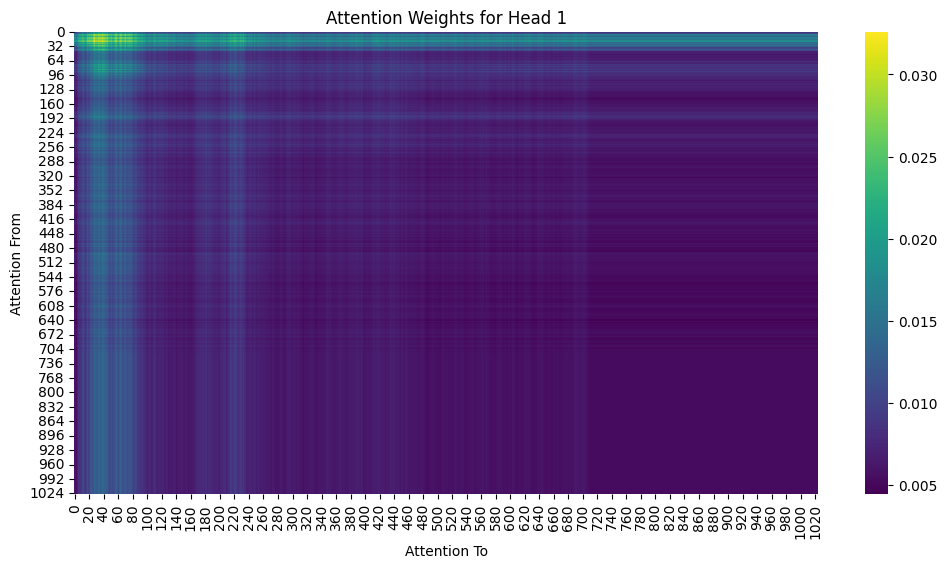

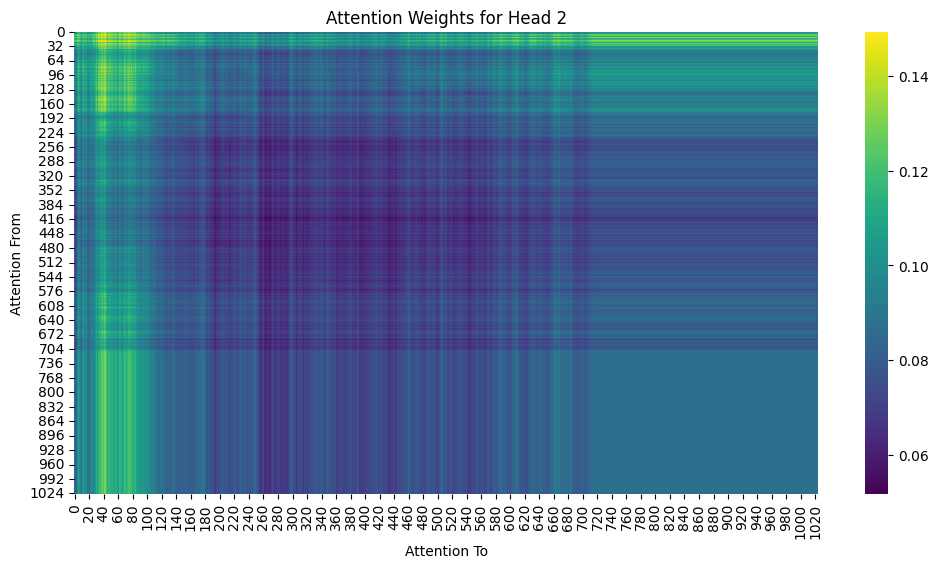

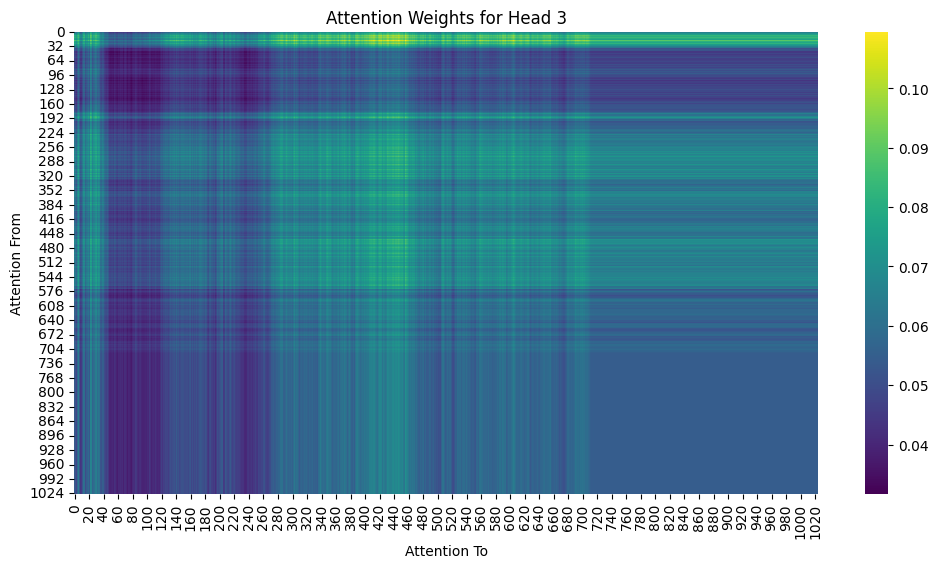

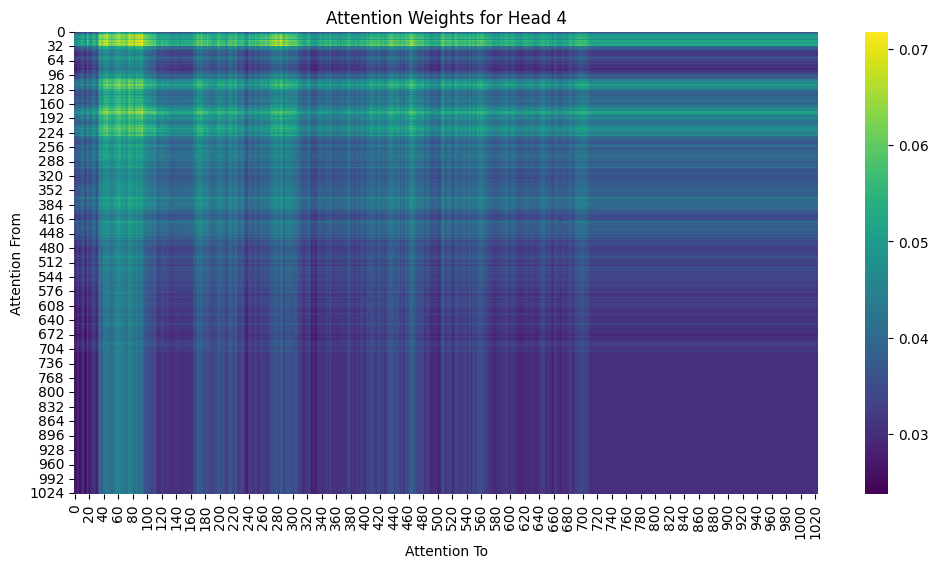

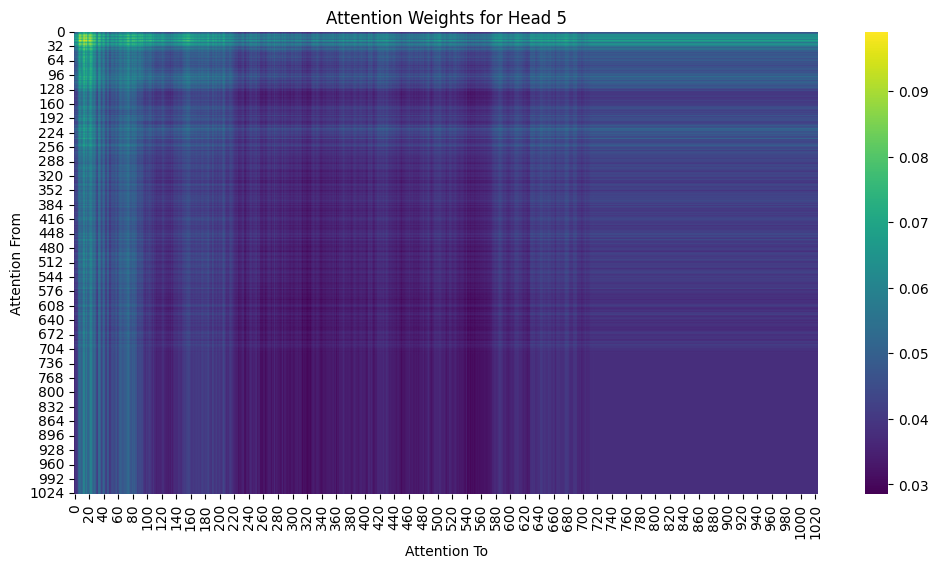

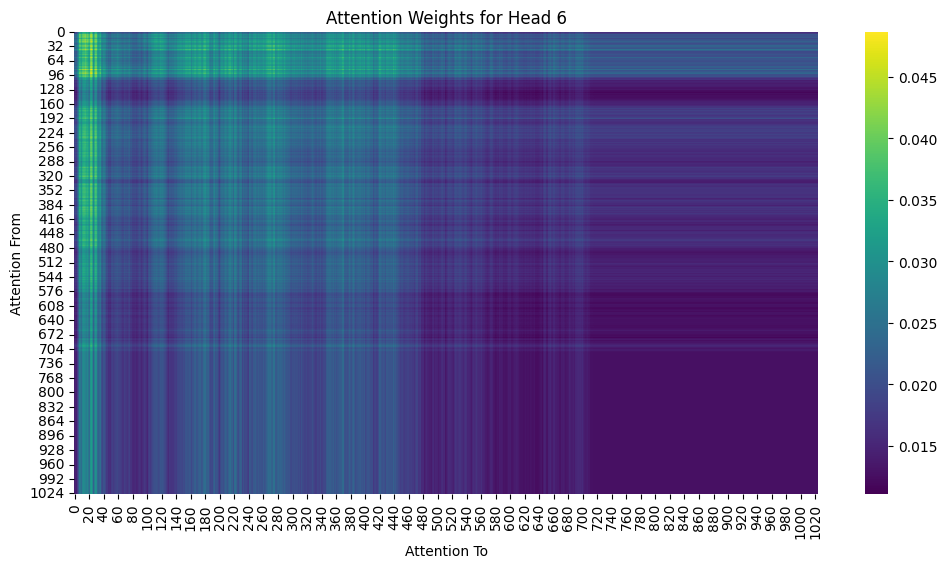

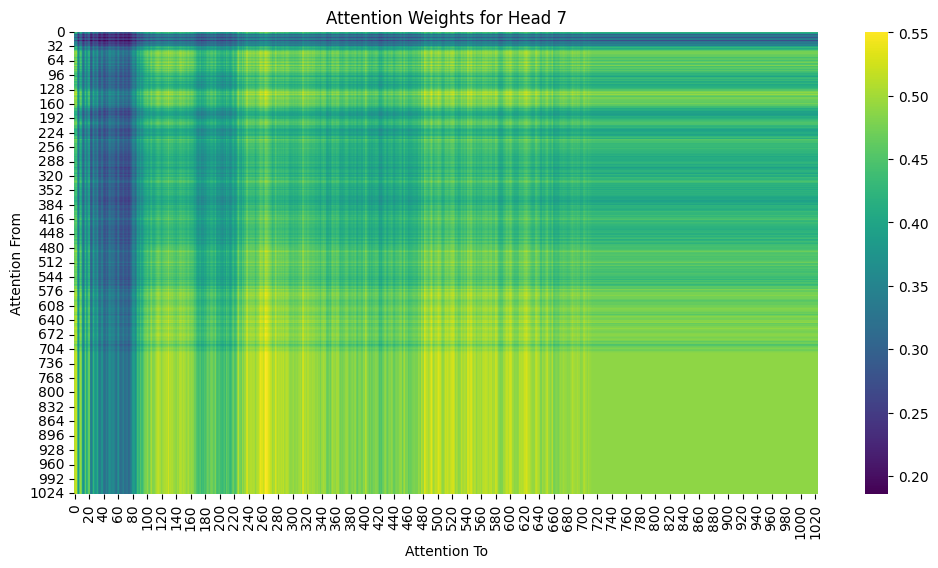

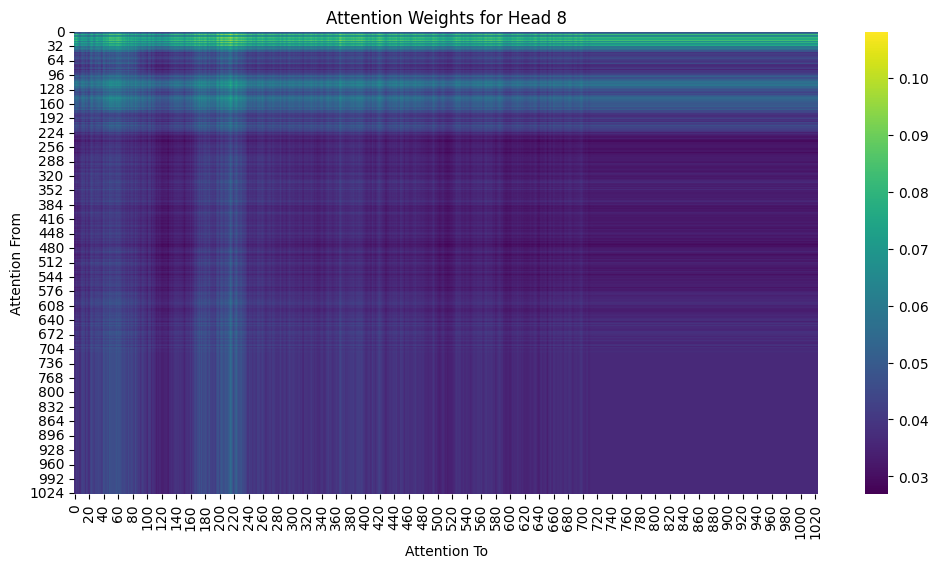

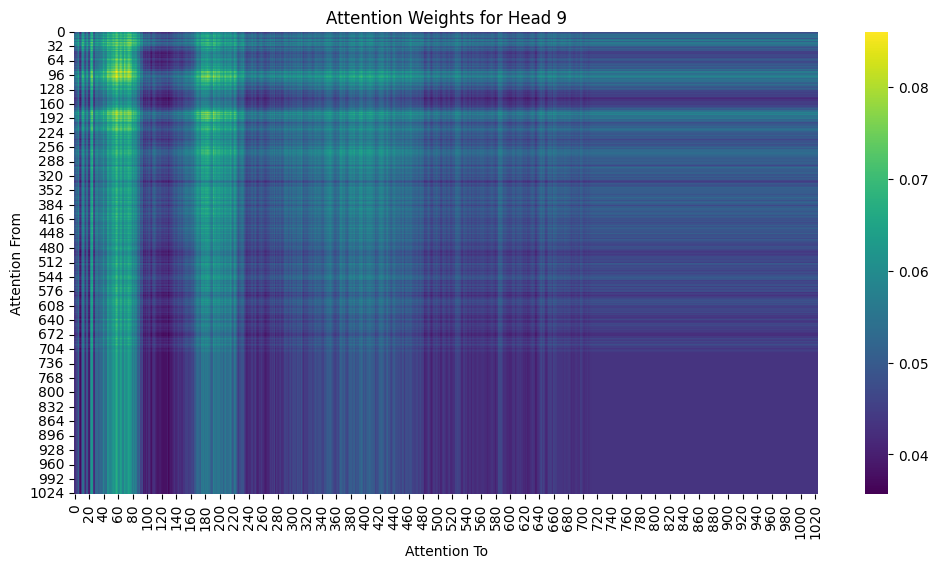

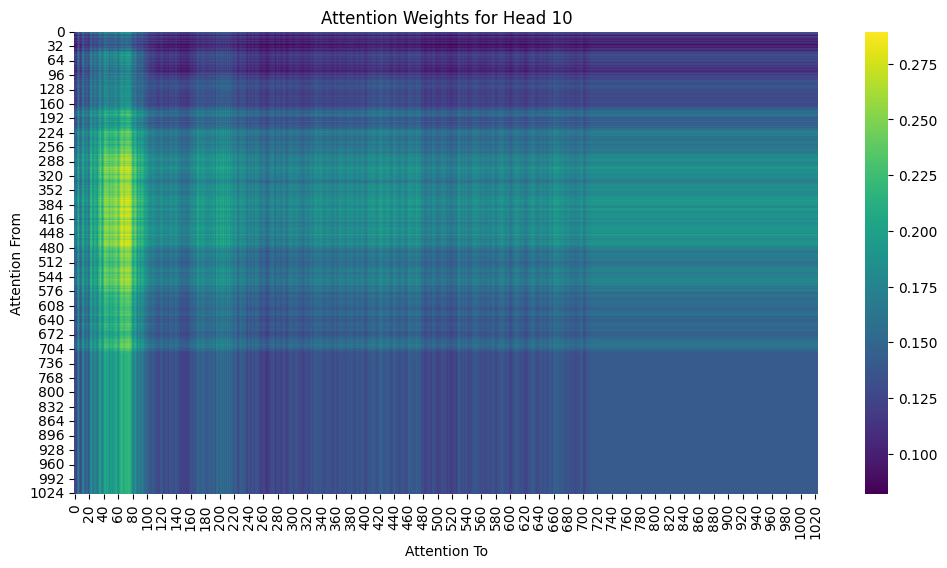

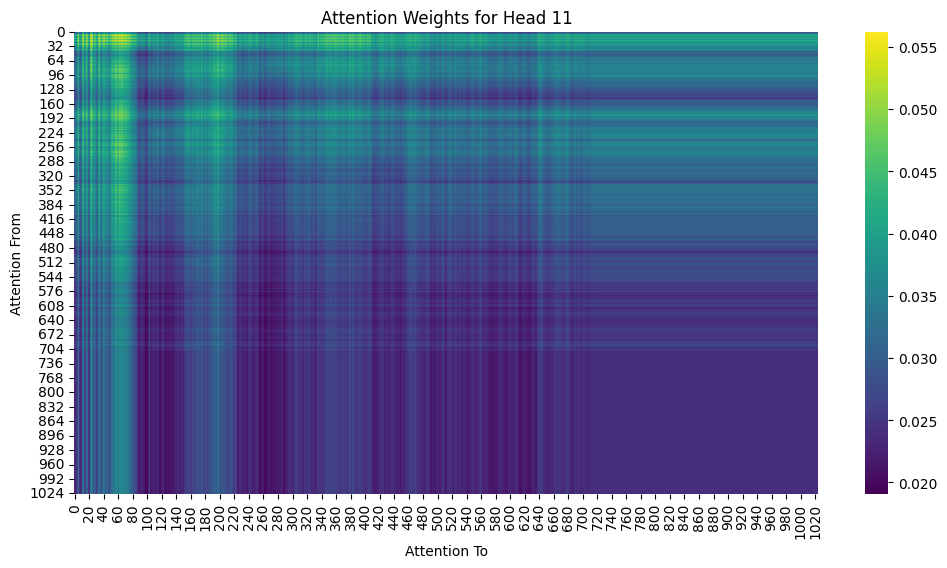

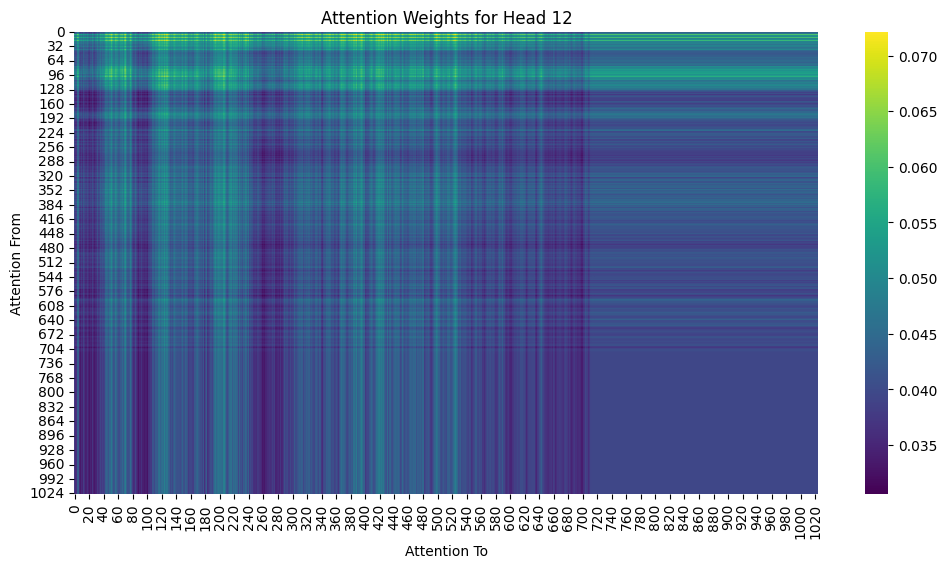

torch.Size([1, 1025, 372])
torch.Size([1, 1025, 372])
tensor([[[ 6286.1719,  -616.3676, -5413.6831,  ..., -3689.9636,
          -3367.7356, -1931.9674],
         [ 6068.6377,  -591.3209, -5298.3940,  ..., -3638.7090,
          -3375.3267, -1802.7360],
         [ 6206.9463,  -628.8372, -5316.0088,  ..., -3598.7856,
          -3339.1057, -1903.5452],
         ...,
         [ 7343.9224,  -971.5571, -5917.7334,  ..., -3772.4426,
          -3418.2581, -2332.0500],
         [ 7343.9214,  -971.5589, -5917.7334,  ..., -3772.4414,
          -3418.2566, -2332.0503],
         [ 7343.9443,  -971.5981, -5917.6987,  ..., -3772.4373,
          -3418.2898, -2332.0518]]], grad_fn=<ViewBackward0>)
CPU times: user 14.6 s, sys: 1.15 s, total: 15.7 s
Wall time: 15.8 s


In [27]:
%%time

# right now it only takes the first file. Change range below for more
for file in files[:1]:
    spec_tensor = torch.tensor(D, dtype=torch.float32).unsqueeze(0)
    # spec_tensor = torch.randn(1, 100, 720)

    embed_dim = spec_tensor.shape[2]
    heads = 12

    self_attention_layer = SelfAttention(embed_dim=embed_dim, heads=heads)
    attention_output, attn_weights = self_attention_layer(spec_tensor)

    for i in range(heads):
        attn_weights_head = attn_weights[0, i, :, :].detach().cpu().numpy()
        plt.figure(figsize=(12, 6))
        sns.heatmap(attn_weights_head, cmap="viridis", cbar=True)
        plt.title(f"Attention Weights for Head {i + 1}")
        plt.xlabel("Attention To")
        plt.ylabel("Attention From")
        plt.show()

    print(spec_tensor.shape)
    print(attention_output.shape)
    print(attention_output)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a8707a63-c175-44fd-8fb6-4db40d528bba' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>